In [1]:
# CELL 1

# import necessary libraries for data manipulation, model evaluation, and plotting
!pip install transformers[torch] accelerate -U plotting

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from transformers import TrainerCallback

import os
import pandas as pd
import datetime
import sys
from sklearn.utils import resample

import torch
from torch.optim import AdamW  # variant of Adam with weight decay
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback

import json
import numpy as np
from transformers import EarlyStoppingCallback

from sklearn.utils.class_weight import compute_class_weight

import datetime
import sklearn
from transformers import get_linear_schedule_with_warmup
from transformers import EarlyStoppingCallback


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
# CELL 2

# data preprocessing

# need to have separate models for each sdoh
dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")

# extract text data and specific SDoH categories from the dataset
text_data = dataset["text"].to_list()
sdoh_data = {
    "sdoh_community_present": dataset["sdoh_community_present"].to_list(),
    "sdoh_community_absent": dataset["sdoh_community_absent"].to_list(),
    "sdoh_education": dataset["sdoh_education"].to_list(),
    "sdoh_economics": dataset["sdoh_economics"].to_list(),
    "sdoh_environment": dataset["sdoh_environment"].to_list(),
    "behavior_alcohol": dataset["behavior_alcohol"].to_list(),
    "behavior_tobacco": dataset["behavior_tobacco"].to_list(),
    "behavior_drug": dataset["behavior_drug"].to_list()
}


# prepare directories for storing train-test split data for each SDoH category
base_path = 'test_train_split/behavior_drug'
os.makedirs(base_path, exist_ok=True)

# Iterate through each SDOH data category to split and save as separate CSV files
for category, data in sdoh_data.items():
    base_path = f"test_train_split/{category}"
    os.makedirs(base_path, exist_ok=True)

    # Split data for the current category into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        text_data, data, random_state=0, train_size=0.8, stratify=data
    )

    # Save all splits as CSV files
    pd.DataFrame({"text": X_train}).to_csv(f"{base_path}/X_train.csv", index=False)
    pd.DataFrame({"text": X_val}).to_csv(f"{base_path}/X_val.csv", index=False)
    pd.DataFrame({category: y_train}).to_csv(f"{base_path}/y_train.csv", index=False)
    pd.DataFrame({category: y_val}).to_csv(f"{base_path}/y_val.csv", index=False)

In [3]:
# CELL 3

# Model training preparation
# functions for saving metrics and plotting loss
def save_metrics_to_csv(json_filepath, csv_filename):
    with open(json_filepath) as file:
        data = json.load(file)

        log_history = data['log_history']
        df = pd.DataFrame(log_history)

        df.to_csv(csv_filename, index=False)

def plot_metric_from_tensor(log_dir, output_dir, steps_per_epoch):

    # Calculate steps_per_epoch based on training data and training arguments
    # steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    graph1_data = event_acc.Scalars("eval/loss")
    graph2_data = event_acc.Scalars("train/loss")

    # Use actual step numbers to convert to epochs, in case of early stopping
    epochs1 = [min(event.step / steps_per_epoch, training_args.num_train_epochs) for event in graph1_data]
    values1 = [event.value for event in graph1_data]

    epochs2 = [min(event.step / steps_per_epoch, training_args.num_train_epochs) for event in graph2_data]
    values2 = [event.value for event in graph2_data]

    plt.figure(figsize=(10, 6))

    plt.plot(epochs1, values1, label="Validation Loss")
    plt.plot(epochs2, values2, label="Train Loss")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Overlap")
    # plt.show()

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the graph to the specified folder
    plt.savefig(os.path.join(output_dir, 'metrics_plot.png'))
    plt.show()

# evaluation metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def get_latest_checkpoint(folder_path):
    # Get a list of all files and directories in the specified folder
    files_and_dirs = os.listdir(folder_path)

    # Filter only directories (assumed to be checkpoints)
    checkpoint_dirs = [d for d in files_and_dirs if os.path.isdir(os.path.join(folder_path, d))]

    if not checkpoint_dirs:
        print("No checkpoint directories found.")
        return None

    # Extract the checkpoint numbers from the directory names
    checkpoint_numbers = [int(d.split('-')[1]) for d in checkpoint_dirs]

    # Identify the directory with the highest checkpoint number
    latest_checkpoint = os.path.join(folder_path, f"checkpoint-{max(checkpoint_numbers)}")

    return latest_checkpoint

checkpoint_path = '/content/checkpoints/checkpoint_epoch_{epoch}.pth'
best_model_path = '/content/checkpoints/best_model.pth'


# Saving the checkpoints
def save_checkpoint(model, optimizer, epoch, loss, val_loss, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    if is_best:
        torch.save(model.state_dict(), best_model_path)

In [4]:
# CELL 4

# each sdoh will have a separate model
# labels are grouped with similar values

# Define label_columns and their corresponding dictionaries for label mappings
label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]

# Definitions for label mappings
sdbh_alcohol_drug_tobacco = {
    0: 'None',
    1: 'Present',
    2: 'Past',
    3: 'Never',
    4: 'Unsure'
}

sdoh_economics_environment = {
    0: 'None',
    1: 'True',
    2: 'False'
}

sdoh_community_education = {
    0: 'False',
    1: 'True'
}

# SET SDOH
current_sdoh = 'sdoh_community_present'

# Classification report conditional logic for label grouping
# label mapping
if current_sdoh.startswith("behavior"):
    current_sdoh_dict = sdbh_alcohol_drug_tobacco
elif current_sdoh == "sdoh_economics" or current_sdoh == "sdoh_environment":
    current_sdoh_dict = sdoh_economics_environment
else:
    current_sdoh_dict = sdoh_community_education

print(f"Current SDOH: {current_sdoh}")
print(f"Current SDOH Dictionary: {current_sdoh_dict}")

# set num labels depending on sdoh being used
num_labels = len(current_sdoh_dict)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

configuration = GPT2ForSequenceClassification.config_class.from_pretrained("gpt2", num_labels= num_labels)
configuration.pad_token_id = tokenizer.pad_token_id
model = GPT2ForSequenceClassification(configuration)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Current SDOH: sdoh_community_present
Current SDOH Dictionary: {0: 'False', 1: 'True'}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [5]:
# CELL 5

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.02},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# optimizer is used to manage/update the weights of the neural network during training
# ideally, this should minimize the loss function
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

In [6]:
# CELL 6

dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")
text_data = dataset["text"].to_list()
sdoh_data = dataset["sdoh_community_present"].to_list()

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size=0.8,
                                                  stratify=sdoh_data)
max_seq_length = 100

# Calculate the number of trainable parameters in the model
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_MB = num_trainable_params * 4 / (1024 ** 2)
effective_batch = 8 / (50*4*model_size_MB) #gpu/seqlength * 4 * model size

In [7]:
# CELL 7

# define training arguments and start training with the Trainer
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

In [8]:
# CELL 8

# Custom Dataset
class CustomDataset(Dataset):
  # initialize dataset object with 2 main components
    def __init__(self, encodings, labels):
        self.encodings = encodings # encodings should be a dictionary where each key-value pair corresponds to tokenized input data
        self.labels = labels # array-like structure containing labels

    # retrieve a single item from the dataset
    def __getitem__(self, idx):
        try:
            # Retrieve tokenized data for the given index
            # wraps in torch.tensor for PyTorch models
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            # Add the label for the given index to the item dictionary
            # item['labels'] = torch.tensor(float(self.labels[idx]))
            item['labels'] = self.labels[idx]

            return item
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            return None

    # returns the total number of items in the dataset
    def __len__(self):
        return len(self.labels)

In [9]:
# CELL 9
# Class weights
'''
# Calculate class weights
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
classes = np.unique(y_train)
# Convert the class weights to a PyTorch tensor, which is necessary for computation during model training
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# SPRINT 9

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        # Extract 'weights' from kwargs and assign to self
        # passes class weights directly to the trainer
        self.weights = kwargs.pop('weights', None)
        super().__init__(*args, **kwargs) # Initialize the superclass (Trainer) with the remaining arguments

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Override the compute_loss method to include class weights in loss calculation.
        This custom loss computation uses class weights to handle imbalanced datasets.
        """
        labels = inputs.pop("labels") # Extract labels from inputs
        outputs = model(**inputs) # Forward pass
        logits = outputs.logits # Model outputs before activation function
        # Apply class weights if provided
        # Use CrossEntropyLoss for classification tasks
        if self.weights is not None:
           # If class weights are provided, use them to calculate weighted loss
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.weights.to(self.model.device))
        else:
          # Otherwise, use unweighted loss
            loss_fct = torch.nn.CrossEntropyLoss()
        # Calculate loss; .view(-1, num_labels) flattens the logits and labels for comparison
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
'''

'\n# Calculate class weights\nclasses = np.unique(y_train)\nclass_weights = compute_class_weight(class_weight=\'balanced\', classes=classes, y=y_train)\n\n# Convert class weights to a tensor\nclass_weights_tensor = torch.tensor(class_weights, dtype=torch.float)\n\n# SPRINT 9\n\nclass CustomTrainer(Trainer):\n    def __init__(self, *args, **kwargs):\n        # Extract \'weights\' from kwargs and assign to self, remove \'weights\' from kwargs\n        self.weights = kwargs.pop(\'weights\', None)\n        super().__init__(*args, **kwargs)\n\n    def compute_loss(self, model, inputs, return_outputs=False):\n        """\n        Custom loss computation to include class weights\n        """\n        labels = inputs.pop("labels")\n        outputs = model(**inputs)\n        logits = outputs.logits\n        # Apply class weights if provided\n        if self.weights is not None:\n            loss_fct = torch.nn.CrossEntropyLoss(weight=self.weights.to(self.model.device))\n        else:\n         

In [10]:
# CELL 10
# each element in y_train corresponsd to the label of the training sample
# train_encodings contains tokenized text data for training set
train_dataset = CustomDataset(train_encodings, y_train)
# val_encodings contains tokenized text data for the validation set
# y_val is array containing labels for validation data
val_dataset = CustomDataset(val_encodings,y_val)

In [11]:
# CELL 11

timestamp_fortrain = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

tensor_logs = f'./logs/tensor_logs/{timestamp_fortrain}' #create seperate logs for tensor/epoch
os.makedirs(tensor_logs, exist_ok=True)
epoch_logs = f'./logs/epoch_logs/{timestamp_fortrain}'
os.makedirs(epoch_logs, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
<ipython-input-8-58592076ad92>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.653400,0.611458,0.672598,0.624143,0.662157,0.672598
2,0.607600,0.557773,0.727402,0.702655,0.728538,0.727402
3,0.555300,0.531389,0.739502,0.716939,0.743069,0.739502
4,0.539400,0.501546,0.750178,0.735338,0.748544,0.750178
5,0.512500,0.480468,0.760142,0.750163,0.756576,0.760142
6,0.493100,0.464310,0.766548,0.759609,0.762309,0.766548
7,0.481400,0.454347,0.772954,0.765795,0.769382,0.772954
8,0.465800,0.451471,0.778648,0.768888,0.777779,0.778648
9,0.457200,0.437676,0.778648,0.771989,0.775384,0.778648
10,0.448400,0.437871,0.785053,0.776198,0.784287,0.785053


<ipython-input-8-58592076ad92>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-58592076ad92>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-58592076ad92>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-58592076ad92>:12: UserWarning: To copy construct from a 

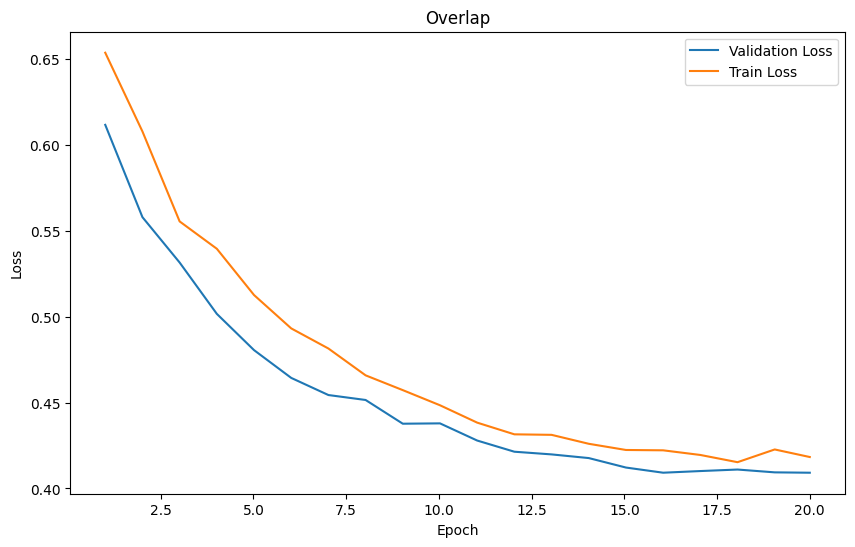

Current SDoH Label: sdoh_community_present
Number of Labels: 2
Performance on Validation Set: {'eval_loss': 0.40917396545410156, 'eval_accuracy': 0.8021352313167259, 'eval_f1': 0.7966738828446938, 'eval_precision': 0.8003069685984527, 'eval_recall': 0.8021352313167259, 'eval_runtime': 2.6393, 'eval_samples_per_second': 532.334, 'eval_steps_per_second': 8.335, 'epoch': 20.0}
The best model checkpoint is saved at: ./logs/epoch_logs/20240329_134614/pytorch_model.bin


In [12]:
# CELL 12

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# weights = get_class_weights(y_train)

# training args - need to adjust
training_args = TrainingArguments(
      output_dir= epoch_logs,  # change to epoch log directory, convert to a text
      logging_strategy='epoch',  # characterize as epoch
      num_train_epochs=20, # have high epoch
      per_device_train_batch_size=16, #reduced batch size
      per_device_eval_batch_size=64,  # gradient accum if batch size of two, 64 approp
      save_strategy= 'epoch',
      warmup_steps=500,
      weight_decay=0.02, #5e-5
      logging_dir= tensor_logs,  # change to tensor logs
      evaluation_strategy="epoch",
      load_best_model_at_end=True,
      metric_for_best_model="eval_loss",
      greater_is_better=False,
      learning_rate=5e-8,
      lr_scheduler_type='linear',

)

trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      #weights=class_weights_tensor,
      #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # 3 is a balance between giving the model enough chance  to improve and stopping early enough to prevent overfitting and unnecessary computation
)

# train the model
trainer.train()

# evaluate the model
evaluation_results = trainer.evaluate()

#readable results
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
latest_checkpoint = get_latest_checkpoint(epoch_logs) # latest checkpoint update to csv

# Assuming the best checkpoint is saved as 'pytorch_model.bin' in the output_dir
best_checkpoint_path = os.path.join(training_args.output_dir, 'pytorch_model.bin')

# Save metrics to CSV
json_path = os.path.join(latest_checkpoint, 'trainer_state.json') if latest_checkpoint else None
if json_path:
    save_metrics_to_csv(json_path, 'eval_metric.csv')  # update metrics

plot_metric_from_tensor(tensor_logs, 'graphs', steps_per_epoch)

#json_path = os.path.join(latest_checkpoint, 'trainer_state.json')
save_metrics_to_csv(json_path, 'eval_metric.csv') #update metrics
save_directory = "/content/saved_models/gpt2"

os.makedirs(save_directory, exist_ok=True)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Current SDoH Label: {current_sdoh}")
print(f"Number of Labels: {num_labels}")
print("Performance on Validation Set:", evaluation_results)
# Print the path of the best checkpoint
print(f"The best model checkpoint is saved at: {best_checkpoint_path}")

In [13]:
# CELL 13

# TEST DATA

import io

# Define the mapping and number of labels for the current SDoH
if current_sdoh.startswith("behavior"):
    num_labels = 5
    current_sdoh_dict = {
        0: 'None',
        1: 'Present',
        2: 'Past',
        3: 'Never',
        4: 'Unsure'
    }
elif current_sdoh == "sdoh_economics" or current_sdoh == "sdoh_environment":
    num_labels = 3
    current_sdoh_dict = {
        0: 'None',
        1: 'True',
        2: 'False'
    }
else:
    num_labels = 2
    current_sdoh_dict = {
        0: 'False',
        1: 'True'
    }

# tokenize the text data
test_encodings = tokenizer(text_data, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
# create a custom dataset for the test data
test_dataset = CustomDataset(test_encodings, sdoh_data)

# Load the model from the best checkpoint for the current SDoH
best_checkpoint_path = os.path.join("/content/logs/epoch_logs/20240329_134614/checkpoint-704")
model = GPT2ForSequenceClassification.from_pretrained(best_checkpoint_path)
model.to(device)

# evaluate the model on the test dataset to get overall metrics
test_results = trainer.evaluate(test_dataset)

# make predictions on the test dataset
results = trainer.predict(test_dataset)
print("Prediction:", results)

# extract the true labels and predicted labels
predicted_labels = results.predictions.argmax(-1)
true_labels = test_dataset.labels

# map numeric labels to the dictionary labels
target = [current_sdoh_dict[i] for i in range(num_labels)]

# print the results and classification report
print("Test Results:", test_results)
report = classification_report(true_labels, predicted_labels, target_names=target)
print("Classification Report for", f'{current_sdoh} :\n', report)

# Compute and print metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="weighted")
recall = recall_score(true_labels, predicted_labels, average="weighted")
f1 = f1_score(true_labels, predicted_labels, average="weighted")

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
})

print("Metrics Table:\n", metrics_df)

# Print true labels and predicted labels
print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)

'''
# Print true labels and predicted labels along with their mapped values from current_sdoh_dict
print("True Labels and Predicted Labels:")
for true_label, predicted_label in zip(true_labels, predicted_labels):
    print("True Label:", target[true_label])
    print("Predicted Label:", current_sdoh_dict[predicted_label])

# Let's also print out current_sdoh_dict for verification
print("Current SDoH Dictionary:")
print(current_sdoh_dict)
'''

<ipython-input-8-58592076ad92>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-8-58592076ad92>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Prediction: PredictionOutput(predictions=array([[ 1.8791766 , -1.4198083 ],
       [ 0.29393184, -0.82058096],
       [-0.87844616,  1.1904135 ],
       ...,
       [-1.6673597 ,  0.8565676 ],
       [ 0.0454807 , -1.0442641 ],
       [-0.43364143,  0.19278085]], dtype=float32), label_ids=array([0, 0, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.38780486583709717, 'test_accuracy': 0.8179359430604982, 'test_f1': 0.8139577229805731, 'test_precision': 0.8163070012638344, 'test_recall': 0.8179359430604982, 'test_runtime': 13.0647, 'test_samples_per_second': 537.709, 'test_steps_per_second': 8.42})
Test Results: {'eval_loss': 0.38780486583709717, 'eval_accuracy': 0.8179359430604982, 'eval_f1': 0.8139577229805731, 'eval_precision': 0.8163070012638344, 'eval_recall': 0.8179359430604982, 'eval_runtime': 13.0647, 'eval_samples_per_second': 537.708, 'eval_steps_per_second': 8.42, 'epoch': 20.0}
Classification Report for sdoh_community_present :
               precision    recall  f1-score   suppor

'\n# Print true labels and predicted labels along with their mapped values from current_sdoh_dict\nprint("True Labels and Predicted Labels:")\nfor true_label, predicted_label in zip(true_labels, predicted_labels):\n    print("True Label:", target[true_label])\n    print("Predicted Label:", current_sdoh_dict[predicted_label])\n\n# Let\'s also print out current_sdoh_dict for verification\nprint("Current SDoH Dictionary:")\nprint(current_sdoh_dict)\n'

In [41]:
# CELL 14

# AUROC (Area under the receiver operating characteristics curve)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

labels = results.label_ids
logits = results.predictions
num_labels = logits.shape[1]  #  num_samples x num_classes

# For binary classification or multi-label classification, use the sigmoid function
# For multi-class classification with single correct class per instance, use the softmax function
if num_labels == 2:
    # Binary classification
    probabilities = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()
    prob = probabilities[:, 1]
    auroc = roc_auc_score(true_labels, prob)
elif num_labels > 2:
    # Multi-class classification
    probabilities = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()
    true_labels = label_binarize(labels, classes=list(range(num_labels)))  # Binarize labels in a one-vs-all fashion
    auroc = [roc_auc_score(true_labels[:, i], probabilities[:, i]) for i in range(num_labels)]
    #auroc = np.mean(aurocs)
else:
    raise ValueError(f"Unexpected num_labels: {num_labels}")

print(f"AUROC: {auroc}")


AUROC: 0.8976989744631153


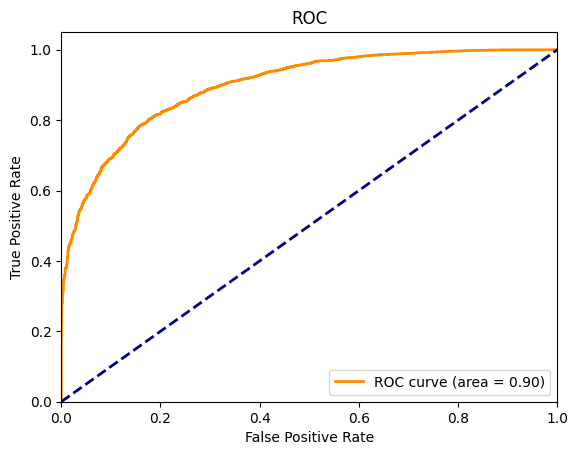

In [46]:
# CELL 15

# ROC CURVE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# determin if binary or multiclass classification

num_classes = probabilities.shape[1]

if num_classes == 2:
    # Binary classification
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, prob)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multi-class classification

    # Binarize the output
    true_labels_bin = label_binarize(true_labels, classes=list(range(num_labels)))
    n_classes = true_labels_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], probabilities[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange'])
    for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


In [47]:
!pip install roc-utils

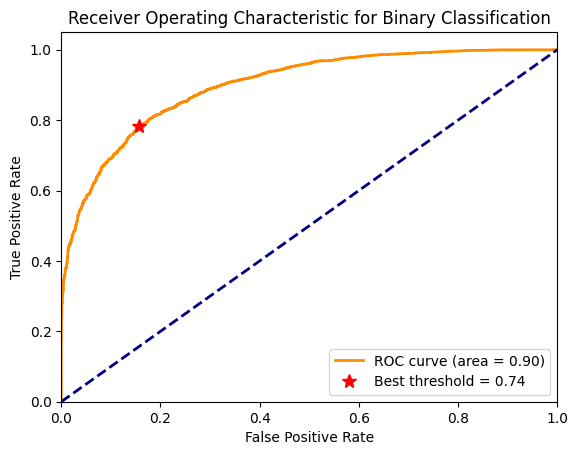

In [51]:
# CELL 16
from roc_utils import *
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

num_classes = probabilities.shape[1]

if num_classes == 2:
    # Binary classification
    proababilities_single_class = probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(true_labels, proababilities_single_class)
    roc_auc = auc(fpr, tpr)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot(optimal_fpr, optimal_tpr, 'r*', markersize=10, label=f'Best threshold = {optimal_threshold:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Binary Classification')
    plt.legend(loc="lower right")
    plt.show()
else:
    # Multi-class classification
    # Compute ROC curve and ROC area for each class
    # Binarize the labels in a one-vs-all fashion

    true_labels_binarized = label_binarize(true_labels, classes=range(n_classes))

    # Initialize dictionaries to hold the FPRs, TPRs, and thresholds for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()

    # Calculate ROC curve for each class
    for i in range(n_classes):
      fpr[i], tpr[i], thresholds[i] = roc_curve(true_labels_binarized[:, i], probabilities[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
      # Euclidean distance for each point on the ROC curve from the top-left corner
      distances = np.sqrt((1 - tpr[i])**2 + fpr[i]**2)
      # index of the smallest distance
      optimal_idx = np.argmin(distances)
      # optimal threshold corresponding to this point
      optimal_threshold = thresholds[i][optimal_idx]

      optimal_fpr, optimal_tpr = fpr[i][optimal_idx], tpr[i][optimal_idx]

      plt.figure()
      plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], 'k--')
      plt.plot(fpr[i][optimal_idx], tpr[i][optimal_idx], 'r*', markersize=10,
             label='Best threshold = {:.2f}'.format(optimal_threshold))
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for class {i}')
      plt.legend(loc="lower right")
      plt.show()

      print(f'Class {i}: Best Threshold = {optimal_threshold:.2f}')
      print(f"Optimal FPR: {optimal_fpr}, Optimal TPR: {optimal_tpr}")


      best_thresholds = dict()

    for i in range(num_classes):
      optimal_idx = np.argmax(tpr[i] - fpr[i])
      best_thresholds[i] = thresholds[i][optimal_idx]
      rint(f'Class {i}: Best Threshold = {best_thresholds[i]:.2f}')


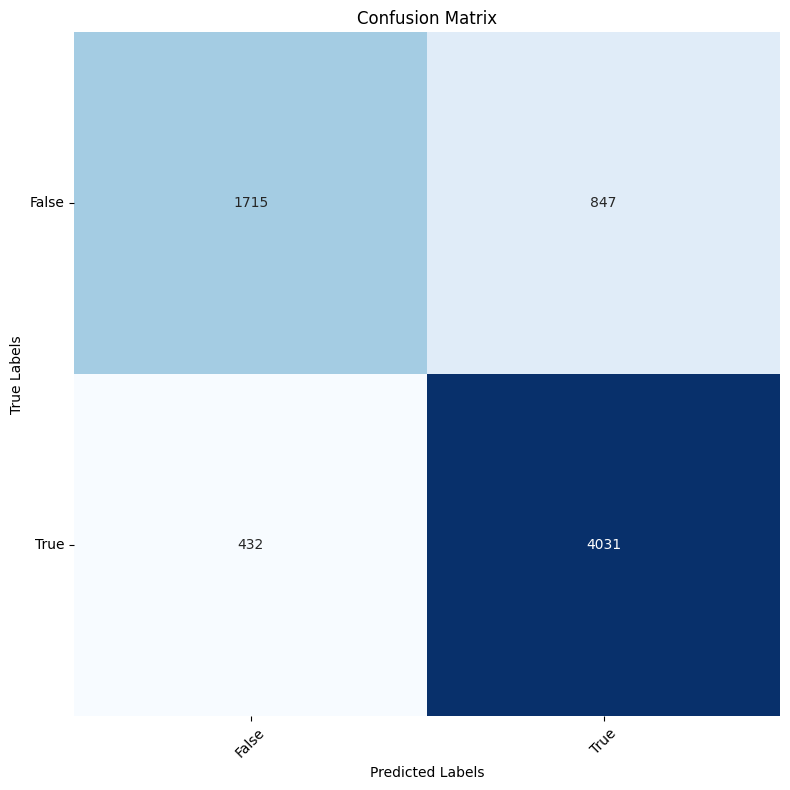

In [52]:
# CELL 17
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = test_dataset.labels

# Calculate the confusion matrix using true labels and predicted labels
cm = confusion_matrix(true_labels, predicted_labels)

# Define the names of the classes to be used in the confusion matrix plot
# Ensure that 'current_sdoh_dict' has been defined in your code as it maps the label numbers to their names
target_names = [current_sdoh_dict[i] for i in sorted(current_sdoh_dict.keys())]

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)

# Label the axes with the actual class names
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Set the tick labels on the axes to correspond to the class names
ax.xaxis.set_ticklabels(target_names, rotation=45)
ax.yaxis.set_ticklabels(target_names, rotation=0)

plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()

In [55]:
# CELL 18

# save all testing data into a csv file

# Ensure target_names is correctly defined based on your current_sdoh_dict
target_names = [current_sdoh_dict[i] for i in range(num_labels)]

# Save classification report to CSV
report_df = pd.DataFrame(report).transpose()
report_filename = f"{current_sdoh}_classification_report.csv"
report_df.to_csv(report_filename)
print(f"Classification report saved to {report_filename}")

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
metrics_filename = f"{current_sdoh}_metrics.csv"
metrics_df.to_csv(metrics_filename, index=False)
print(f"Metrics saved to {metrics_filename}")

# Save AUROC to a CSV
# Assuming auroc is correctly calculated in your previous cells for both binary and multi-class
auroc_df = pd.DataFrame({'AUROC': [auroc] if isinstance(auroc, float) else auroc})
auroc_filename = f"{current_sdoh}_auroc.csv"
auroc_df.to_csv(auroc_filename, index=False)
print(f"AUROC saved to {auroc_filename}")

# Save ROC curve data to CSV
roc_curve_data = []
if isinstance(fpr, dict):  # This checks if fpr (and similarly tpr, thresholds) is structured for multi-class
    for i in range(num_classes):
        for fpr_val, tpr_val, threshold in zip(fpr[i], tpr[i], thresholds[i]):
            roc_curve_data.append({
                'Class': i,
                'FPR': fpr_val,
                'TPR': tpr_val,
                'Threshold': threshold
            })
elif isinstance(fpr, np.ndarray):  # This is expected for binary classification
    # Here, you're dealing with binary classification, so there's only one set of fpr, tpr, thresholds
    for fpr_val, tpr_val, threshold in zip(fpr, tpr, thresholds):
        roc_curve_data.append({
            'Class': 0,  # Assuming binary classification is treated as a single class '0'
            'FPR': fpr_val,
            'TPR': tpr_val,
            'Threshold': threshold
        })
else:
    print("Unexpected data structure for ROC curve data.")

roc_curve_df = pd.DataFrame(roc_curve_data)
roc_curve_filename = f"{current_sdoh}_roc_curve_data.csv"
roc_curve_df.to_csv(roc_curve_filename, index=False)
print(f"ROC curve data saved to {roc_curve_filename}")

# Save confusion matrix to CSV
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
cm_filename = f"{current_sdoh}_confusion_matrix.csv"
cm_df.to_csv(cm_filename)
print(f"Confusion matrix saved to {cm_filename}")


Classification report saved to sdoh_community_present_classification_report.csv
Metrics saved to sdoh_community_present_metrics.csv
AUROC saved to sdoh_community_present_auroc.csv
ROC curve data saved to sdoh_community_present_roc_curve_data.csv
Confusion matrix saved to sdoh_community_present_confusion_matrix.csv
